In [17]:
# 📦 Instalar bibliotecas necessárias (evita repetições)
!pip install -q unidecode nltk pandas matplotlib seaborn

# 📚 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
from google.colab import files

# 🔽 Baixar stopwords em português
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# 📁 Upload do dataset
print("📁 Faça o upload do arquivo fakeWhatsApp.BR_2018.csv")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ✅ Carregar base de dados e salvar como variável global
global df_raw
df_raw = pd.read_csv(filename)
print("✅ Dataset carregado com sucesso! Formato:", df_raw.shape)


📁 Faça o upload do arquivo fakeWhatsApp.BR_2018.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving fakeWhatsApp.BR_2018.csv to fakeWhatsApp.BR_2018 (1).csv
✅ Dataset carregado com sucesso! Formato: (282601, 19)


<ipython-input-17-2e740426df13>:24: DtypeWarning:

Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.



In [18]:
# Remover stopwords
def remove_stopwords(text):
    tokens = str(text).split()
    tokens = [unidecode(w.lower()) for w in tokens if unidecode(w.lower()) not in stopwords_pt]
    return " ".join(tokens)

df = df_raw.copy()
df["text_limpo"] = df["text"].apply(remove_stopwords)

# Identificar usuários que estão em múltiplos grupos
usuarios_multigrupo = df.groupby('id')['group'].nunique()
usuarios_multigrupo = usuarios_multigrupo[usuarios_multigrupo > 1].index
df_multi = df[df['id'].isin(usuarios_multigrupo)].copy()

# Identificar mensagens replicadas por usuário em grupos diferentes
duplicadas = df_multi.groupby(['id', 'text_limpo'])['group'].nunique().reset_index()
duplicadas = duplicadas[duplicadas['group'] > 1]
mensagens_virais = duplicadas[['id', 'text_limpo']]
df_virais = df.merge(mensagens_virais, on=['id', 'text_limpo'], how='inner')


### Gráfico 1 – Visualização do flood de mensagens replicadas
**Inserir na página 95 da tese.**

Este gráfico ilustra o comportamento de replicação de mensagens em sequência por usuários em diferentes grupos, caracterizando o fenômeno do 'flood'. Deve constar na LISTA DE GRÁFICOS e ser inserido no Capítulo 6 da tese, na seção 6.2 (p. 95).

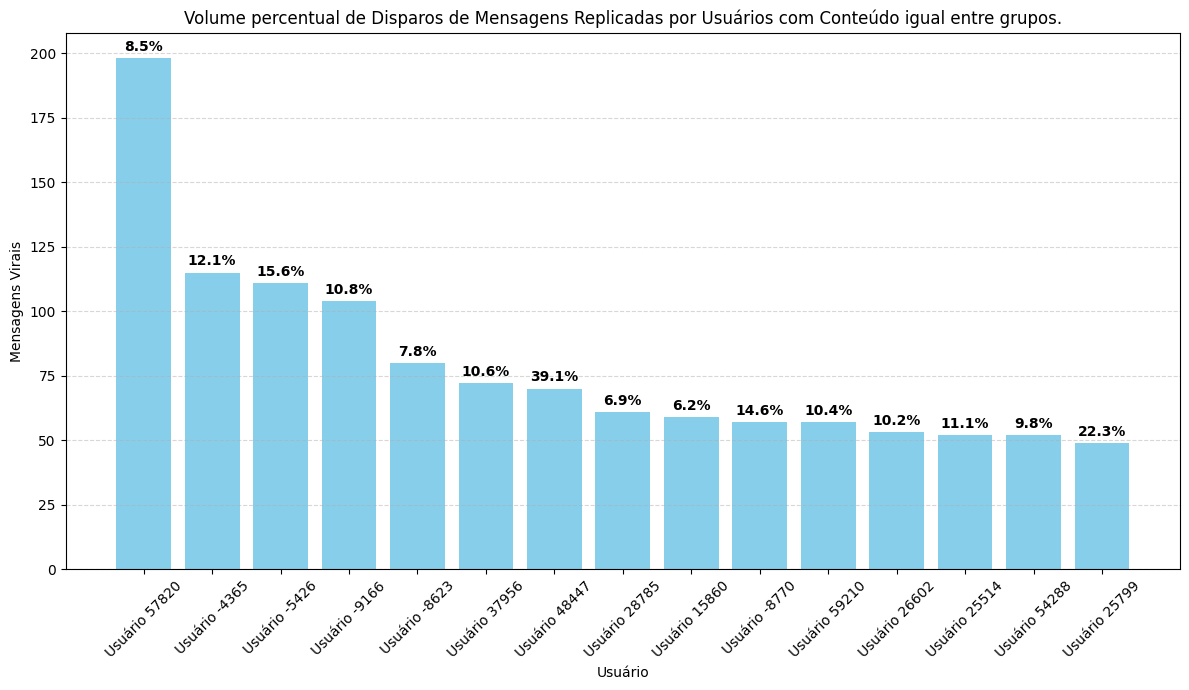

In [19]:
# Mensagens totais por usuário
total_mensagens = df.groupby('id')['text'].count().reset_index()
total_mensagens.columns = ['id', 'total_mensagens']

# Mensagens virais por usuário
virais_por_usuario = df_virais.groupby('id')['text_limpo'].nunique().reset_index()
virais_por_usuario.columns = ['id', 'mensagens_virais']

# Mesclar e calcular percentual
df_usuarios = total_mensagens.merge(virais_por_usuario, on='id', how='left')
df_usuarios['mensagens_virais'] = df_usuarios['mensagens_virais'].fillna(0)
df_usuarios['percent_virais'] = (df_usuarios['mensagens_virais'] / df_usuarios['total_mensagens']) * 100

# Top 15 usuários
top_usuarios = df_usuarios.sort_values(by='mensagens_virais', ascending=False).head(15)
top_usuarios['nome_usuario'] = top_usuarios['id'].astype(str).str[:5].apply(lambda x: f"Usuário {x}")

# Gráfico
plt.figure(figsize=(12, 7))
bars = plt.bar(top_usuarios['nome_usuario'], top_usuarios['mensagens_virais'], color='skyblue')

# Percentuais
for bar, pct in zip(bars, top_usuarios['percent_virais']):
    height = bar.get_height()
    plt.annotate(f'{pct:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Volume percentual de Disparos de Mensagens Replicadas por Usuários com Conteúdo igual entre grupos.')
plt.xlabel('Usuário')
plt.ylabel('Mensagens Virais')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [20]:
from collections import Counter
import numpy as np

# Copiar o DataFrame original
df = df_raw.copy()

# ✅ Acrescentar tokens personalizados às stopwords
stopwords_customizadas = stopwords_pt.union({
    '___________________', '-', '*', '(', ')'
})

# ✅ Limpeza e normalização dos textos
def limpar_texto(texto):
    palavras = str(texto).split()
    palavras = [unidecode(p.lower()) for p in palavras if unidecode(p.lower()) not in stopwords_customizadas]
    return " ".join(palavras)

df['text_limpo'] = df['text'].apply(limpar_texto)
df['n_palavras'] = df['text_limpo'].apply(lambda x: len(x.split()))

# ✅ Considerar apenas mensagens com mais de 7 palavras
df_longas = df[df['n_palavras'] > 7].copy()

# ✅ Identificar mensagens replicadas por usuário
grupo_msg = df_longas.groupby(['id', 'text_limpo'])['group'].nunique().reset_index()
grupo_msg = grupo_msg[grupo_msg['group'] > 1]

# ✅ Identificar os 10 usuários com mais mensagens replicadas
top_ids = grupo_msg['id'].value_counts().head(10).index.tolist()

# ✅ Total de grupos existentes (fixo da base)
TOTAL_GRUPOS = 59

# ✅ Construir tabela final
tabela = []

for usuario in top_ids:
    mensagens_usuario = grupo_msg[grupo_msg['id'] == usuario]
    textos_usuario = mensagens_usuario['text_limpo'].tolist()

    # Grupos únicos atingidos pelas mensagens replicadas
    grupos_alvo = df_longas[
        (df_longas['id'] == usuario) &
        (df_longas['text_limpo'].isin(textos_usuario))
    ]['group'].nunique()

    perc = (grupos_alvo / TOTAL_GRUPOS) * 100

    # Palavras mais frequentes nas mensagens replicadas
    todas_palavras = " ".join(textos_usuario).split()
    mais_freq = [w.capitalize() for w, _ in Counter(todas_palavras).most_common(4)]
    palavras_freq = ", ".join(mais_freq)

    tabela.append([
        f"Usuário ID {str(usuario)[:5]}",
        perc,
        f"{perc:.1f}% ({grupos_alvo}/{TOTAL_GRUPOS})",
        palavras_freq
    ])

# ✅ Criar DataFrame final
df_tese = pd.DataFrame(tabela, columns=[
    "Usuário propagador",
    "percentual_numerico",  # Usado só para ordenar
    "% dos grupos que atingiu",
    "4 principais palavras repetidas nas msgs"
])

# ✅ Ordenar do maior para o menor percentual
df_tese = df_tese.sort_values(by="percentual_numerico", ascending=False).drop(columns=["percentual_numerico"])

# ✅ Exibir a tabela
import IPython.display as display
display.display(df_tese)

# ✅ Exportar para CSV
df_tese.to_csv("tabela_usuarios_propagadores.csv", index=False)
files.download("tabela_usuarios_propagadores.csv")


,Usuário propagador,% dos grupos que atingiu,4 principais palavras repetidas nas msgs
0,Usuário ID -9166,13.6% (8/59),"Tocantins, Bolsonaro, Grupos, Cidades"
3,Usuário ID -4365,11.9% (7/59),"Bolsonaro, Nao, R$, Vamos"
5,Usuário ID 54288,11.9% (7/59),"Bolsonaro, Tocantins, Grupos, Apoiadores"
4,Usuário ID 57820,11.9% (7/59),"Nao, Bolsonaro, Vamos, Dia"
1,Usuário ID -5426,10.2% (6/59),"Nao, Bolsonaro, R$, Contra"
2,Usuário ID -8623,5.1% (3/59),"Nao, (pag, Haddad, Publica"
6,Usuário ID -8770,5.1% (3/59),"Nao, Vc, Apenas, *seja"
7,Usuário ID 18407,5.1% (3/59),"Candidato, Campanha, Sargento, Moreira"
8,Usuário ID 25799,3.4% (2/59),"Bolsonaro, Nao, Deus, Todos"
9,Usuário ID 25514,3.4% (2/59),"Nao, Bolsonaro, Haddad, Brasil"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-21-c549c25310e0>:35: UserWarning:

Glyph 128232 (\N{INCOMING ENVELOPE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128232 (\N{INCOMING ENVELOPE}) missing from font(s) DejaVu Sans.



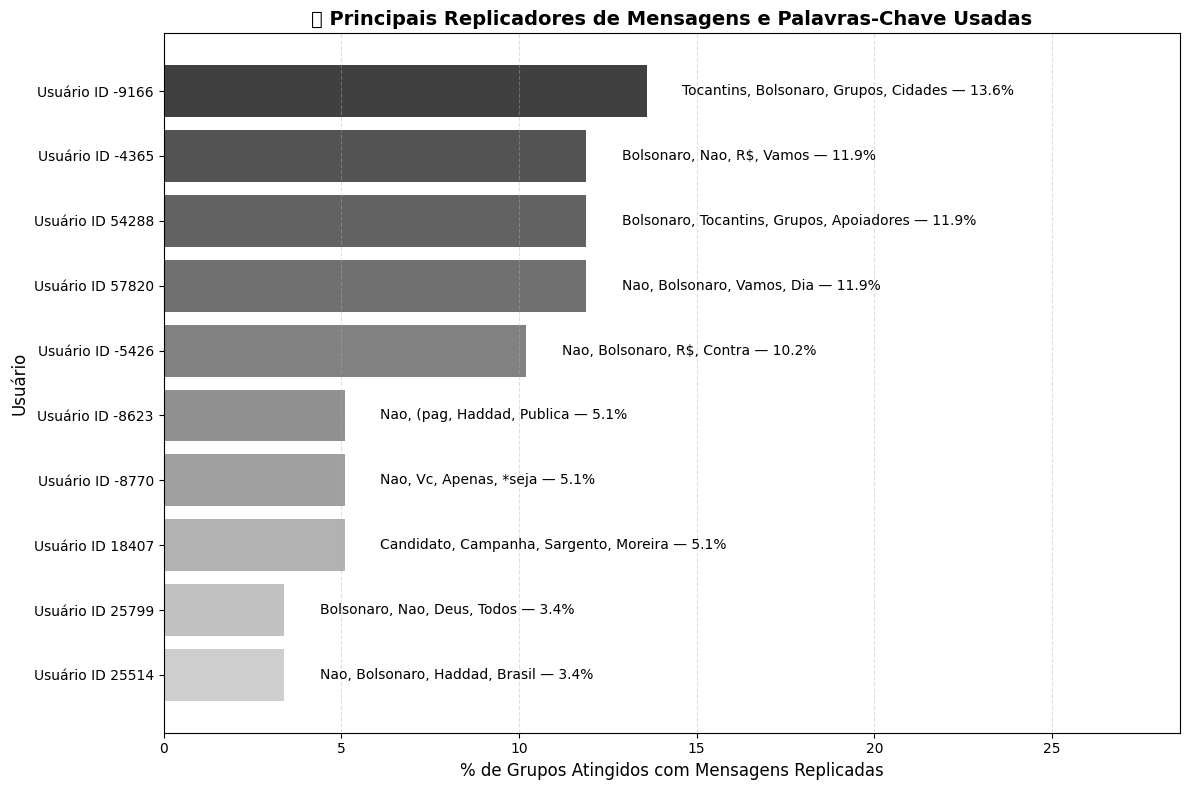

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ✅ Criar cópia do DataFrame original
df_plot = df_tese.copy()

# ✅ Extrair percentual numérico da coluna e ordenar
df_plot['percentual'] = df_plot['% dos grupos que atingiu'].str.extract(r'(\d+\.?\d*)')[0].astype(float)
df_plot = df_plot.sort_values(by='percentual', ascending=False)

# ✅ Definir tons de cinza do mais escuro (maior percentual) para o mais claro
n = len(df_plot)
colors = [cm.Greys(0.8 - 0.5 * (i / (n - 1))) for i in range(n)]  # invertido

# ✅ Tamanho do gráfico
plt.figure(figsize=(12, 8))

# ✅ Gráfico de barras horizontais
bars = plt.barh(df_plot['Usuário propagador'], df_plot['percentual'], color=colors)

# ✅ Rótulo com palavras e valor percentual
for bar, palavras, pct in zip(bars, df_plot['4 principais palavras repetidas nas msgs'], df_plot['percentual']):
    width = bar.get_width()
    label = f"{palavras} — {pct:.1f}%"
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, label,
             va='center', fontsize=10, color='black')

# ✅ Estilização
plt.xlabel('% de Grupos Atingidos com Mensagens Replicadas', fontsize=12)
plt.ylabel('Usuário', fontsize=12)
plt.title('📨 Principais Replicadores de Mensagens e Palavras-Chave Usadas', fontsize=14, weight='bold')
plt.xlim(0, max(df_plot['percentual']) + 15)
plt.gca().invert_yaxis()  # maior em cima
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


DIAGRAMA DE SANKEY

In [22]:
# Instalação das bibliotecas necessárias
!pip install -q pandas plotly nltk unidecode

# Imports
import pandas as pd
from collections import Counter
from unidecode import unidecode
import plotly.graph_objects as go
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# ✅ Imports necessários
import pandas as pd
import numpy as np
from collections import Counter
from unidecode import unidecode
import plotly.graph_objects as go
from nltk.corpus import stopwords
from IPython.display import display

# ✅ Leitura segura do dataset
df = pd.read_csv("fakeWhatsApp.BR_2018.csv", low_memory=False)

# ✅ Stopwords
stopwords_pt = set(stopwords.words("portuguese"))

# ✅ Função para limpar texto
def limpar_texto(texto):
    palavras = str(texto).split()
    palavras = [unidecode(p.lower()) for p in palavras if unidecode(p.lower()) not in stopwords_pt]
    return " ".join(palavras)

# ✅ Limpeza e filtragem
df['text_limpo'] = df['text'].astype(str).apply(limpar_texto)
df['n_palavras'] = df['text_limpo'].apply(lambda x: len(x.split()))
df = df[df['n_palavras'] > 7].copy()

# ✅ Identificar mensagens replicadas por usuário
grupo_msg = df.groupby(['id', 'text_limpo'])['group'].nunique().reset_index()
grupo_msg = grupo_msg[grupo_msg['group'] > 1]

# ✅ Selecionar top 10 usuários que mais replicaram mensagens
top_users = grupo_msg['id'].value_counts().head(10).index.tolist()

# ✅ Criar lista com dados para tabela e sankey
sankey_data = []

for usuario in top_users:
    textos_usuario = grupo_msg[grupo_msg['id'] == usuario]['text_limpo'].tolist()

    for texto in textos_usuario[:3]:  # limitar a 3 mensagens por usuário
        grupos = df[(df['id'] == usuario) & (df['text_limpo'] == texto)]['group'].unique().tolist()
        for grupo in grupos:
            sankey_data.append([
                f"Usuário ID {str(usuario)[:5]}",
                grupo,
                texto[:60] + ("..." if len(texto) > 60 else "")  # limitar texto para visualização
            ])

# ✅ Criar DataFrame para a tabela
df_sankey = pd.DataFrame(sankey_data, columns=["Usuário propagador", "Grupo de destino", "Mensagem replicada"])
display(df_sankey.head(15))


,Usuário propagador,Grupo de destino,Mensagem replicada
0,Usuário ID -9166,2018_2,https://youtu.be/_phxp_dpaik marcha interior...
1,Usuário ID -9166,2018_17,https://youtu.be/_phxp_dpaik marcha interior...
2,Usuário ID -9166,2018_33,https://youtu.be/_phxp_dpaik marcha interior...
3,Usuário ID -9166,2018_2,*atencao direita tocantins* hoje 21 horas far...
4,Usuário ID -9166,2018_17,*atencao direita tocantins* hoje 21 horas far...
5,Usuário ID -9166,2018_33,*atencao direita tocantins* hoje 21 horas far...
6,Usuário ID -9166,2018_36,*atencao direita tocantins* hoje 21 horas far...
7,Usuário ID -9166,2018_52,*atencao direita tocantins* hoje 21 horas far...
8,Usuário ID -9166,2018_55,*atencao direita tocantins* hoje 21 horas far...
9,Usuário ID -9166,2018_2,"*ultimo dia campanha ""eu dou sangue brasil""* d..."


In [24]:
# ✅ Imports
import plotly.graph_objects as go

# ✅ Etapa 1: Criar dicionário de índices para Sankey
labels = pd.unique(df_sankey[['Usuário propagador', 'Grupo de destino', 'Mensagem replicada']].values.ravel())
label_to_index = {label: idx for idx, label in enumerate(labels)}

# ✅ Etapa 2: Criar listas source → target → value
source = []
target = []
value = []

# Fluxo 1: Usuário → Grupo
for _, row in df_sankey.iterrows():
    source.append(label_to_index[row['Usuário propagador']])
    target.append(label_to_index[row['Grupo de destino']])
    value.append(1)

# Fluxo 2: Grupo → Mensagem
for _, row in df_sankey.iterrows():
    source.append(label_to_index[row['Grupo de destino']])
    target.append(label_to_index[row['Mensagem replicada']])
    value.append(1)

# ✅ Etapa 3: Criar gráfico Sankey com Plotly
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgray"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color="rgba(150,150,150,0.4)"
    ))])

# ✅ Etapa 4: Layout
fig.update_layout(
    title_text="🔁 Fluxo de Replicação: Usuários → Grupos → Mensagens",
    font_size=12,
    title_font_size=16
)

# ✅ Exibir
fig.show()


In [25]:
import plotly.graph_objects as go

fig1 = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=25,  # espaçamento entre os nós
        thickness=20,
        line=dict(color="black", width=0.4),
        label=labels,
        color="lightgrey",
        hoverlabel=dict(
            bgcolor="white",
            font=dict(color="black", size=14, family="Arial")
        )
        # ❌ 'font' removido — não é aceito por Sankey node
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

fig1.update_layout(
    title_text="🔁 Fluxo de Replicação de Mensagens entre Usuários, Alcance e Conteúdo",
    title_x=0.5,
    font=dict(size=14, color="black", family="Arial"),  # texto geral
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=70, r=70, t=100, b=70)  # mais espaço para labels
)

fig1.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import plotly.graph_objects as go

# ✅ Reutiliza df_sankey criado anteriormente

# ✅ Atualizar mapeamento
labels = pd.unique(df_sankey[['Usuário', 'Alcance (%)', 'Mensagem']].values.ravel())
label_map = {label: idx for idx, label in enumerate(labels)}

source, target, value = [], [], []

# Usuário → Alcance
for _, row in df_sankey.iterrows():
    source.append(label_map[row['Usuário']])
    target.append(label_map[row['Alcance (%)']])
    value.append(1)

# Alcance → Mensagem
for _, row in df_sankey.iterrows():
    source.append(label_map[row['Alcance (%)']])
    target.append(label_map[row['Mensagem']])
    value.append(1)

# ✅ Gráfico Sankey otimizado para impressão
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=25,
        line=dict(color="black", width=1),
        label=labels,
        color="gray"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color="rgba(50,50,50,0.85)"  # cinza escuro quase sólido
    )
)])

fig.update_layout(
    title_text="🔁 Fluxo de Disparos de Mensagens Replicadas por Usuários — Grupos Atingidos e Conteúdo",
    title_font=dict(size=18, color='black', family="Arial"),
    font=dict(size=13, color="black", family="Arial"),
    paper_bgcolor="white",
    plot_bgcolor="white",
    height=800
)

fig.show()


In [28]:
import plotly.graph_objects as go

# ✅ Criar índice único para labels
labels = pd.unique(df_sankey[['Usuário', 'Alcance (%)', 'Mensagem']].values.ravel())
label_map = {label: idx for idx, label in enumerate(labels)}

# ✅ Fonte para cada label (usuário, grupo, mensagem)
source, target, value = [], [], []
colors = []

# Cores distintas por camada
user_color = 'rgba(128, 189, 255, 0.8)'
group_color = 'rgba(180, 180, 180, 0.8)'
msg_color = 'rgba(80, 80, 80, 0.8)'

# Fluxo: Usuário → Alcance
for _, row in df_sankey.iterrows():
    src = label_map[row['Usuário']]
    tgt = label_map[row['Alcance (%)']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(user_color)

# Fluxo: Alcance → Mensagem
for _, row in df_sankey.iterrows():
    src = label_map[row['Alcance (%)']]
    tgt = label_map[row['Mensagem']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(group_color)

# ✅ Gráfico Sankey estilizado
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgray",
        hoverlabel=dict(bgcolor="white", font=dict(color="black"))
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors,
    )
)])

# ✅ Layout claro e impresso
fig.update_layout(
    title_text="🔁 Replicação de Mensagens: Usuários → Alcance em Grupos → Conteúdo Repetido",
    title_x=0.5,
    font=dict(size=12, family="Arial", color="black"),
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=900
)

fig.show()


In [35]:
import plotly.graph_objects as go

# ✅ Criar índice único para labels
labels = pd.unique(df_sankey[['Usuário', 'Alcance (%)', 'Mensagem']].values.ravel())
label_map = {label: idx for idx, label in enumerate(labels)}

# ✅ Fonte para cada label (usuário, grupo, mensagem)
source, target, value = [], [], []
colors = []

# 🎨 Tons de verde e cinza inspirados no WhatsApp
user_color = 'rgba(37, 211, 102, 0.8)'     # verde WhatsApp claro
group_color = 'rgba(18, 140, 126, 0.7)'    # verde escuro
msg_color = 'rgba(88, 88, 88, 0.8)'        # cinza para mensagens

# Fluxo: Usuário → Alcance
for _, row in df_sankey.iterrows():
    src = label_map[row['Usuário']]
    tgt = label_map[row['Alcance (%)']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(user_color)

# Fluxo: Alcance → Mensagem
for _, row in df_sankey.iterrows():
    src = label_map[row['Alcance (%)']]
    tgt = label_map[row['Mensagem']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(group_color)

# ✅ Gráfico Sankey estilizado
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=25,
        thickness=22,
        line=dict(color="black", width=0.4),
        label=labels,
        color="lightgrey",
        hoverlabel=dict(
            bgcolor="white",
            font=dict(color="black", size=14, family="Arial")
        )
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

# ✅ Layout para impressão
fig.update_layout(
    title_text="Usuários que mais enviaram mensagens replicadas →  % de Grupos que alcançou → Conteúdo propagado",
    title_x=0.5,
    font=dict(size=14, family="Arial", color="black"),
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=80, r=80, t=100, b=80)
)

fig.show()


In [37]:
import plotly.graph_objects as go

# ✅ Criar índice único para labels
labels = pd.unique(df_sankey[['Usuário', 'Alcance (%)', 'Mensagem']].values.ravel())
label_map = {label: idx for idx, label in enumerate(labels)}

# ✅ Fonte para cada label (usuário, grupo, mensagem)
source, target, value = [], [], []
colors = []

# 🎨 Tons de verde e cinza inspirados no WhatsApp
user_color = 'rgba(37, 211, 102, 0.8)'     # verde WhatsApp claro
group_color = 'rgba(18, 140, 126, 0.7)'    # verde escuro
msg_color = 'rgba(88, 88, 88, 0.8)'        # cinza para mensagens

# Fluxo: Usuário → Alcance
for _, row in df_sankey.iterrows():
    src = label_map[row['Usuário']]
    tgt = label_map[row['Alcance (%)']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(user_color)

# Fluxo: Alcance → Mensagem
for _, row in df_sankey.iterrows():
    src = label_map[row['Alcance (%)']]
    tgt = label_map[row['Mensagem']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(group_color)

# ✅ Gráfico Sankey com fonte aumentada
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=40,              # Espaçamento entre os nós
        thickness=30,        # Altura da barra
        line=dict(color="black", width=0.8),
        label=labels,
        color="lightgrey",
        hoverlabel=dict(
            bgcolor="white",
            font=dict(color="black", size=20, family="Arial")  # Fonte grande no hover
        )
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

# ✅ Layout final com fonte maior e margens ajustadas
fig.update_layout(
    title_text="Usuários que mais enviaram mensagens replicadas → % de Grupos que alcançou → Conteúdo propagado",
    title_x=0.5,
    font=dict(size=20, family="Arial", color="black"),  # Fonte dos labels
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=1400,
    margin=dict(l=120, r=120, t=120, b=120)
)

fig.show()


In [40]:
import plotly.graph_objects as go

# ✅ Criar índice único para labels
labels = pd.unique(df_sankey[['Usuário', 'Alcance (%)', 'Mensagem']].values.ravel())
label_map = {label: idx for idx, label in enumerate(labels)}

# ✅ Fonte para cada label (usuário, grupo, mensagem)
source, target, value = [], [], []
colors = []

# 🎨 Cores inspiradas no WhatsApp
user_color = 'rgba(37, 211, 102, 0.8)'     # verde claro
group_color = 'rgba(18, 140, 126, 0.7)'    # verde escuro
msg_color = 'rgba(80, 80, 80, 0.85)'       # cinza

# Fluxo: Usuário → Alcance
for _, row in df_sankey.iterrows():
    src = label_map[row['Usuário']]
    tgt = label_map[row['Alcance (%)']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(user_color)

# Fluxo: Alcance → Mensagem
for _, row in df_sankey.iterrows():
    src = label_map[row['Alcance (%)']]
    tgt = label_map[row['Mensagem']]
    source.append(src)
    target.append(tgt)
    value.append(1)
    colors.append(group_color)

# ✅ Cores para os nós (simulando “caixa” ao redor dos rótulos)
node_colors = []
for label in labels:
    if "Usuário" in label:
        node_colors.append('rgba(37, 211, 102, 0.6)')
    elif "%" in label:
        node_colors.append('rgba(18, 140, 126, 0.6)')
    else:
        node_colors.append('rgba(50, 50, 50, 0.6)')  # mensagens

# ✅ Criar o Sankey
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=45,
        thickness=35,
        line=dict(color="black", width=1.5),  # “borda da caixa”
        label=labels,
        color=node_colors,
        hoverlabel=dict(
            bgcolor="white",
            font=dict(color="black", size=22, family="Arial")
        )
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

# ✅ Layout com destaque para visualização impressa
fig.update_layout(
    font=dict(size=22, family="Arial", color="black"),  # Fonte dos labels visíveis
    paper_bgcolor='white',
    plot_bgcolor='white',
    height=1600,
    margin=dict(l=100, r=100, t=120, b=100)
)

fig.show()
